In [0]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [0]:
path_df = "/content/gdrive/My Drive/InstagramDatasetRegression.csv"

In [0]:
Regression_data = pd.read_csv(path_df, encoding='utf-8-sig')

In [5]:
Regression_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20668 entries, 0 to 20667
Data columns (total 47 columns):
edge_felix_video_timeline                      20668 non-null int64
edge_follow                                    20668 non-null int64
edge_followed_by                               20668 non-null int64
edge_owner_to_timeline_media                   20668 non-null int64
highlight_reel_count                           20668 non-null int64
is_business_account                            20668 non-null bool
is_verified                                    20668 non-null bool
comments_disabled                              20668 non-null bool
is_video                                       20668 non-null bool
time_between                                   20668 non-null float64
number_of_likes/mean                           20668 non-null float64
Friday                                         20668 non-null int64
Monday                                         20668 non-null int64
Saturda

In [6]:
from sklearn.preprocessing import MinMaxScaler
continuous = ["edge_felix_video_timeline", "edge_follow", "edge_followed_by", "edge_owner_to_timeline_media", "highlight_reel_count", "time_between", "hour_of_day", "hr_sin", "hr_cos", "mean_likes", "mean_comments"]
 
# performin min-max scaling each continuous feature column to
# the range [0, 1]
cs = MinMaxScaler()
Data_Continuous = cs.fit_transform(Regression_data[continuous])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
Data_Continuous_df = pd.DataFrame(Data_Continuous, columns=continuous)

In [0]:
Regression_data_continuous = Regression_data.drop(continuous,axis=1)

In [0]:
Regression_data_continuous = pd.concat([Regression_data_continuous, Data_Continuous_df], axis = 1)

In [0]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
 

# define our MLP network
model1 = Sequential()
model1.add(Dense(64, input_dim=46, activation="relu"))
model1.add(Dense(32, activation="relu"))
model1.add(Dense(16, activation="relu"))
model1.add(Dense(8, activation="relu"))
model1.add(Dense(4, activation="relu"))
model1.add(Dense(1, activation="linear"))

In [0]:
from sklearn.model_selection import train_test_split
X = Regression_data_continuous
maxPrice = X["number_of_likes/mean"].max()
Y = X["number_of_likes/mean"] / maxPrice
Y = Y.values
X = X.drop('number_of_likes/mean', axis = 1).values
X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=42)

In [0]:
from keras.optimizers import Adam
opt = Adam(lr=1e-4, decay=1e-4 / 200)
model1.compile(loss="mean_squared_error", optimizer=opt)

In [16]:
model1.fit(X_train, Y_train, validation_data=(X_test, Y_test),
	epochs=30, batch_size=8)

Instructions for updating:
Use tf.cast instead.
Train on 16534 samples, validate on 4134 samples
Epoch 1/30
16534/16534 [==============================] - 9s 560us/step - loss: 0.0107 - val_loss: 0.0075
Epoch 2/30
16534/16534 [==============================] - 8s 468us/step - loss: 0.0069 - val_loss: 0.0074
Epoch 3/30
16534/16534 [==============================] - 8s 471us/step - loss: 0.0067 - val_loss: 0.0074
Epoch 4/30
16534/16534 [==============================] - 8s 469us/step - loss: 0.0067 - val_loss: 0.0074
Epoch 5/30
16534/16534 [==============================] - 8s 468us/step - loss: 0.0067 - val_loss: 0.0074
Epoch 6/30
16534/16534 [==============================] - 9s 535us/step - loss: 0.0066 - val_loss: 0.0074
Epoch 7/30
16534/16534 [==============================] - 8s 480us/step - loss: 0.0066 - val_loss: 0.0074
Epoch 8/30
16534/16534 [==============================] - 8s 505us/step - loss: 0.0066 - val_loss: 0.0074
Epoch 9/30
16534/16534 [==============================]

In [17]:
preds1 = model1.predict(X_test)
diff1 = preds1.flatten() - Y_test
Yitemindex = np.where(Y_test==0)
Yitemindex

(array([ 611,  626, 1418, 2078, 3107]),)

In [18]:
minVal = np.amin(Y_test[Y_test != np.amin(Y_test)])
print(minVal)
np.put(Y_test, 611, minVal)
np.put(Y_test, 626, minVal)
np.put(Y_test, 1418, minVal)
np.put(Y_test, 2078, minVal)
np.put(Y_test, 3107, minVal)

0.008646305557331068


In [19]:
percentDiff1 = (diff1 / Y_test) * 100

absPercentDiff1 = np.abs(percentDiff1)
mean1 = np.mean(absPercentDiff1)
std1 = np.std(absPercentDiff1)
 
import locale
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("avg likes/mean:")
print(Regression_data_continuous["number_of_likes/mean"].mean())
print("std likes/mean:")
print(Regression_data_continuous["number_of_likes/mean"].std())
print("mean absolute percentage difference: {:.2f}%, std absolute percentage difference.: {:.2f}%".format(mean1, std1))

avg likes/mean:
1.0000000000000009
std likes/mean:
0.5068692569675557
mean absolute percentage difference: 55.40%, std absolute percentage difference.: 128.68%


In [20]:
from sklearn import metrics
preds_full = model1.predict(X)
print(np.sqrt(metrics.mean_squared_error(Y_test, preds1)))
print(np.sqrt(metrics.mean_squared_error(Y, preds_full)))

0.0864695704296728
0.08078056539765215


In [21]:
print(metrics.r2_score(Y_test, preds1))
print(metrics.r2_score(Y, preds_full))

0.019700601273513585
0.08941136518106363


In [0]:
preds_full = preds_full.reshape((20668,))

In [0]:
Y1 = Regression_data_continuous["number_of_likes/mean"] 

preds_full = preds_full * maxPrice


In [24]:
compare = pd.DataFrame({'Prediction': preds_full, 'Actual' : Y1})
compare.head(23)

,Prediction,Actual
0,0.972450,0.697678
1,0.970846,1.132276
2,1.005902,0.641902
3,1.009154,1.072790
4,0.977843,1.059753
5,1.057359,1.177626
6,1.023160,1.101678
7,1.107260,1.154272
8,1.053476,1.012914
9,1.000863,1.057489


In [0]:
Small_difference = abs((Regression_data_continuous["number_of_likes/mean"].values) - preds_full)  < 0.05
med_difference = abs((Regression_data_continuous["number_of_likes/mean"].values) - preds_full)  < 0.25
Big_difference = abs((Regression_data_continuous["number_of_likes/mean"].values) - preds_full)  > 0.5

In [26]:
Regression_data_continuous[Small_difference].shape[0]

2197

In [29]:
Regression_data_continuous[med_difference].shape[0]

10069

In [0]:
idx_vals = Regression_data_continuous[Small_difference].index.values
idx_big_vals = Regression_data_continuous[Big_difference].index.values

In [31]:
compare1 = compare.ix[idx_vals]
compare2 = compare.ix[idx_big_vals]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [32]:
compare1.head(10)

,Prediction,Actual
7,1.107260,1.154272
8,1.053476,1.012914
15,1.033897,1.064485
19,0.999555,0.955169
41,0.917901,0.936587
52,0.762586,0.722908
58,1.040622,1.084068
83,1.022935,0.983480
110,0.990788,0.967900
115,0.851600,0.845677


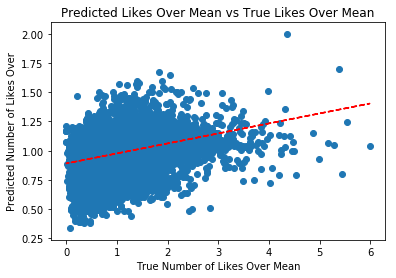

In [34]:
from  matplotlib import pyplot 
pyplot.scatter(Regression_data_continuous["number_of_likes/mean"].values, preds_full)
z = np.polyfit(Regression_data_continuous["number_of_likes/mean"].values, preds_full, 1)
p = np.poly1d(z)
pyplot.plot(Regression_data_continuous["number_of_likes/mean"].values,p(Regression_data_continuous["number_of_likes/mean"].values),"r--")
pyplot.title("Predicted Likes Over Mean vs True Likes Over Mean")
pyplot.xlabel("True Number of Likes Over Mean")
pyplot.ylabel("Predicted Number of Likes Over")
pyplot.show()

In [0]:
model1.save("/content/gdrive/My Drive/data_model.h5")